In [1]:
import cv2
import imutils
import matplotlib.pyplot as plt 
import numpy as np 

In [2]:
img = cv2.imread('../samples/2.jpg')

In [3]:
img.dtype

dtype('uint8')

In [4]:
img.shape

(890, 912, 3)

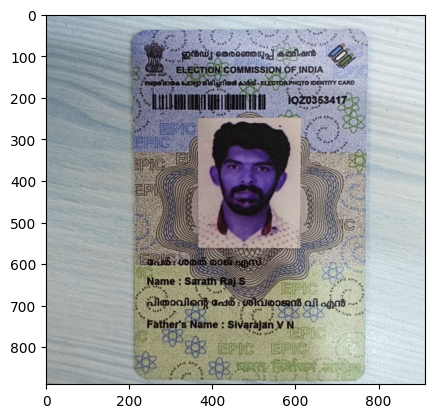

In [5]:
plt.imshow(img)

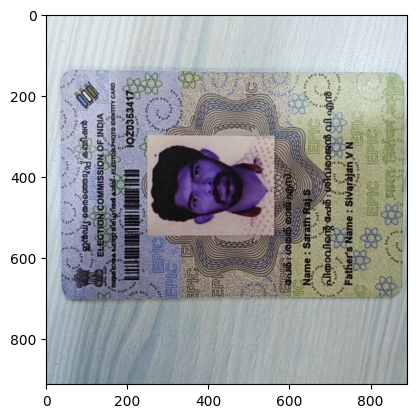

In [6]:
# rotate the image
img_rotated = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.imshow(img_rotated)

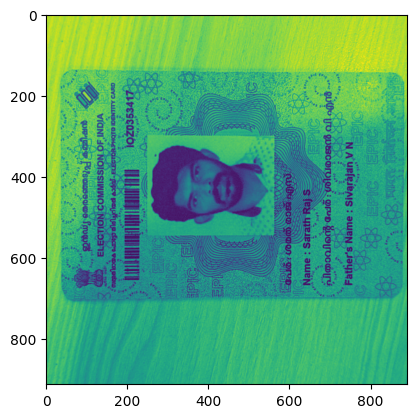

In [7]:
# gayscale image
img_gray = cv2.cvtColor(img_rotated, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray)

In [8]:
img_gray.shape

(912, 890)

In [9]:
cv2.imwrite("../samples/sample_grayscale.jpg", img_gray)

True

In [10]:
def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = newImage
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(
        blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=5)

    # Find all contours
    contours, hierarchy = cv2.findContours(
        dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    minAreaRect = cv2.minAreaRect(largestContour)

    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    angle = 90 - angle
    return 1.0 * angle

# Rotate the image around its center


def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(
        newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

# Deskew image


def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    print(angle)
    return rotateImage(cvImage, -1.0 * angle)


0.0


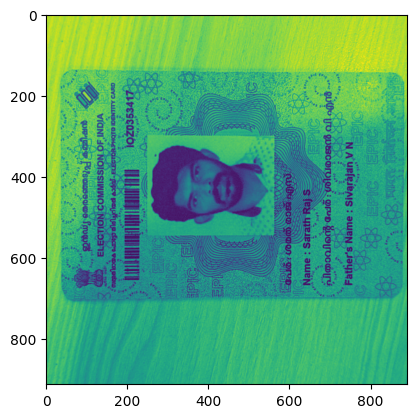

In [11]:
img_deskewed = deskew(img_gray)
plt.imshow(img_deskewed)
plt.show()


In [12]:
gray = cv2.bilateralFilter(img_deskewed, 11, 17, 17)
edged = cv2.Canny(gray, 30, 200)
cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:10]
screenCnt = None

# loop over our contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.015 * peri, True)
	# if our approximated contour has four points, then
	# we can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break


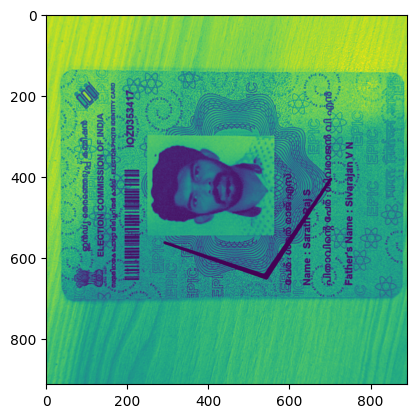

In [13]:
cv2.drawContours(img_deskewed, [screenCnt], -1, (0, 0, 0), 6)
plt.imshow(img_deskewed)

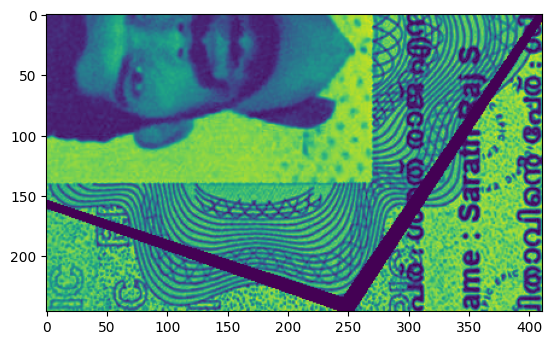

In [14]:
x, y, w, h = cv2.boundingRect(screenCnt)
cropped_deskewed_img = img_deskewed[y:y+h, x:x+w]
plt.imshow(cropped_deskewed_img)
